### **Итоговое задание Александра Соколова **  
### по Проекту 7. Ford vs Ferrari: определяем модель авто по фото
####   Юнит 8. Нейронные сети (отредактирован 13.01.2021)
---

### 1. Импорты, инициализация глобальных констант, контроль инициализации пакетов и оборудования
#### 1.1. Импорты

In [5]:
import os
from datetime import datetime as dt
import numpy as np
import pandas as pd
import sys

import tensorflow as tf
from tensorflow.keras.preprocessing import image

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential as S
from sklearn.model_selection import train_test_split
from tensorflow import keras

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.8.5 (default, Jul 28 2020, 12:59:40) 
Numpy        : 1.19.4


In [5]:
import utils_module09122020 as utils

### 1.2. Глобальные константы

In [9]:
# проверка пути в папке input для корректного назначения глобальной константы PATH_TO_FILE
print(os.listdir("./input"))

['sf-dl-car-classification']


In [10]:
CURRENT_DIR = './'  # имя текущей директории для локальной машины 
# CURRENT_DIR = '../'  # имя текущей директории для для каггл
PATH_to_FILE = CURRENT_DIR+'input/sf-dl-car-classification/'  # имя директории с исходными файлами
PATH_to_WORKDIR = CURRENT_DIR+'working/'  # имя рабочей директории

RANDOM_SEED = 42  # фиксируем состояние генератора псевдо-случайных чисел для воспроизводимости результата
np.random.seed(RANDOM_SEED)

!pip3 freeze > requirements.txt  # фиксируем версии всех пакетов для воспроизводимости результата

CURRENT_DATE = dt.now().strftime('[%d.%m.%Y]')  # фиксируем текущую дату для контроля версий экспериментов

#### 1.3. Проверка подключения и параметров GPU

In [11]:
!nvidia-smi

/bin/bash: nvidia-smi: команда не найдена


### 2. Импорт и предобработка данных
#### 2.1. Импорт данных

In [12]:
df_train = pd.read_csv(PATH_to_FILE + 'train.csv')
df_submit = pd.read_csv(PATH_to_FILE + 'sample-submission.csv')

#### 2.2. Предобработка данных

In [13]:
# создание в рабочей папке отдельной папки для разъархивированных картинок авто
PATH_to_IMAGES = utils.mkdir(PATH_to_WORKDIR, 'images_of_car') 


Директория с именем (images_of_car) успешно создана в (./working/).
Путь к новой папке (./working//images_of_car/) возвращен в переменную.


In [14]:
utils.unzip(PATH_to_FILE, PATH_to_IMAGES, ['train.zip', 'test.zip'], 'с картинками авто')

Распаковываем zip-архивы с картинками авто:
1. train.zip..................... Распакован.
2. test.zip...................... Распакован.
===
Текущее состояние папки (./working//images_of_car/):= ['train', 'test_upload']


### 3. Разведовательный анализ данных (EDA)
#### 3.1. Статистический отчет

In [15]:
df_train.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [16]:
utils.describe_without_plots_all_collumns(df_train, short=True)

,имя признака,тип,# значений,# пропусков(NaN),# уникальных,минимум,среднее,макс,медиана
0,Id,object,15561,0,15561,NaN,NaN,NaN,NaN
1,Category,int64,15561,0,10,0,4.337,9,4


In [17]:
df_train.Category.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

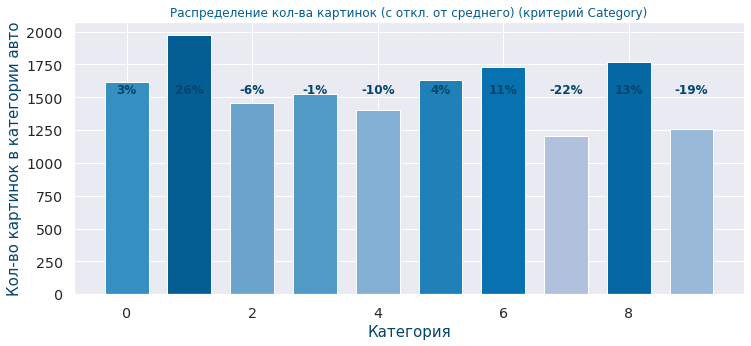

In [18]:
utils.simple_plot_barv('Распределение кол-ва картинок (с откл. от среднего)', 'Category', df_train, 1.3, 'Категория', 'Кол-во картинок в категории авто')


#### 3.2. Визуальный анализ картинок

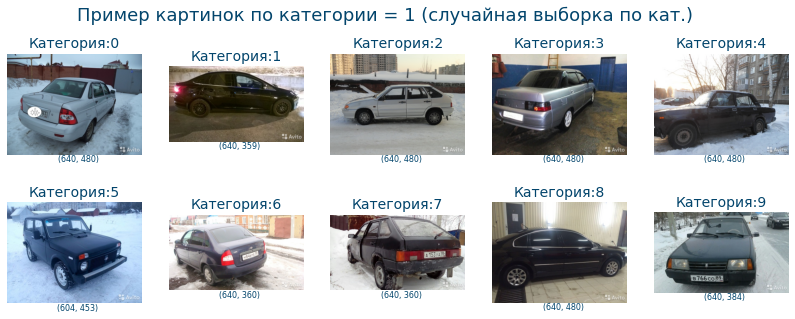

In [19]:
utils.images_from_dataset_with_path('Пример картинок по категории = 1 (случайная выборка по кат.)', 'Категория:',PATH_to_IMAGES+'train/', df_train, 'Category', range(10), 'Id', RANDOM_SEED, True)

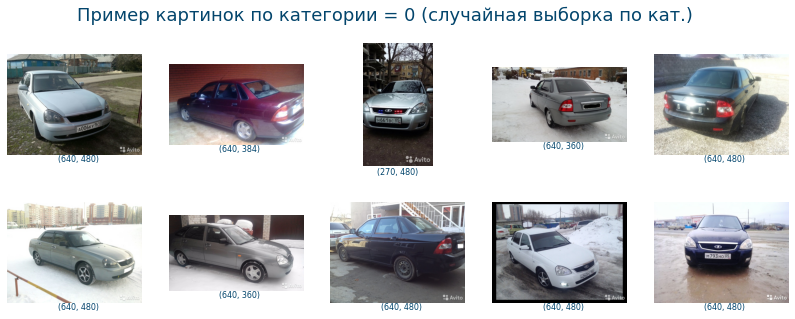

In [20]:
utils.images_from_dataset_with_path('Пример картинок по категории = 0 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.zeros(10, dtype=int), 'Id', RANDOM_SEED+2, False)

0 категория = Lada Priora

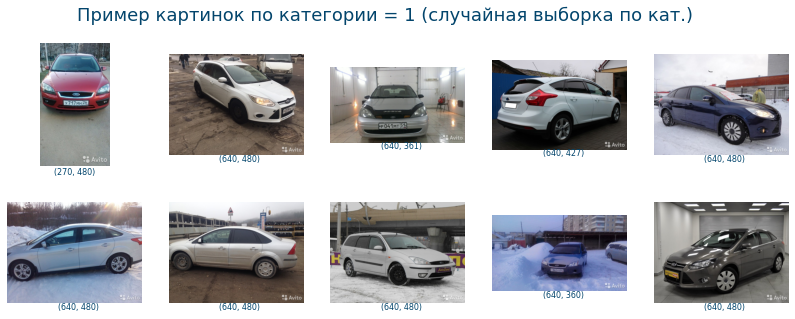

In [21]:
utils.images_from_dataset_with_path('Пример картинок по категории = 1 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int), 'Id', RANDOM_SEED, False)

1 категория = Ford Focus

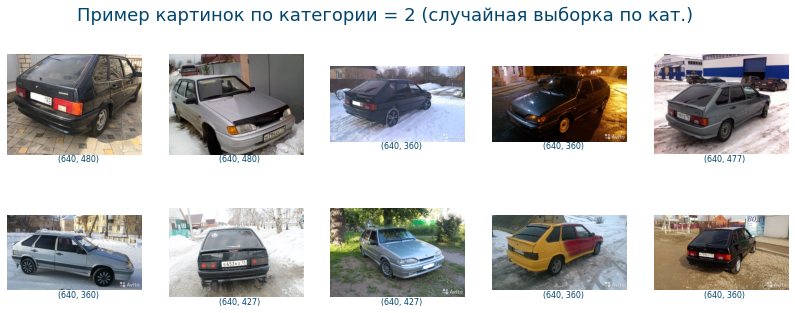

In [22]:
utils.images_from_dataset_with_path('Пример картинок по категории = 2 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*2, 'Id', RANDOM_SEED, False)

2 категория = Lada Samara 2114

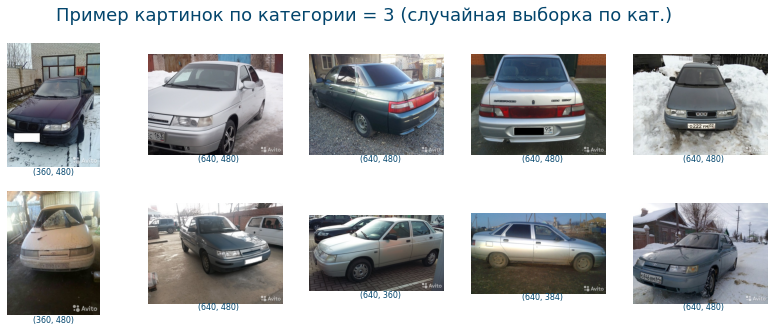

In [23]:
utils.images_from_dataset_with_path('Пример картинок по категории = 3 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*3, 'Id', RANDOM_SEED+1, False)

3 категория = Lada 110

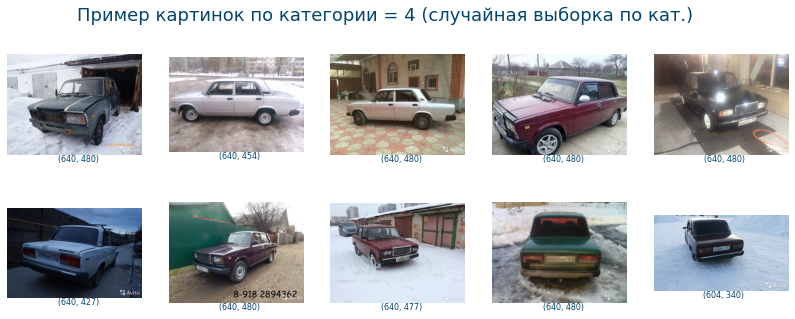

In [24]:
utils.images_from_dataset_with_path('Пример картинок по категории = 4 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*4, 'Id', RANDOM_SEED, False)

4 категория = Lada 2107

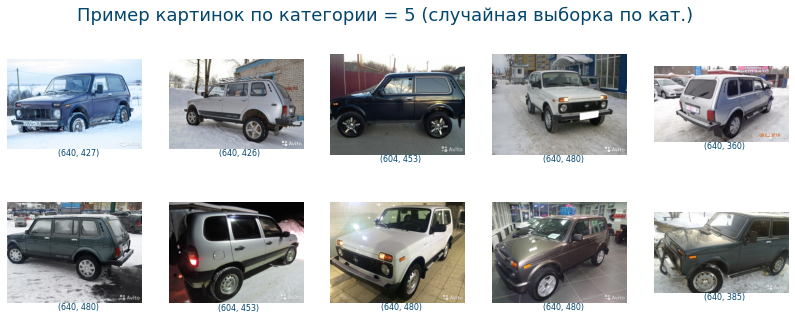

In [25]:
utils.images_from_dataset_with_path('Пример картинок по категории = 5 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*5, 'Id', RANDOM_SEED, False)

5 категория - Lada Niva

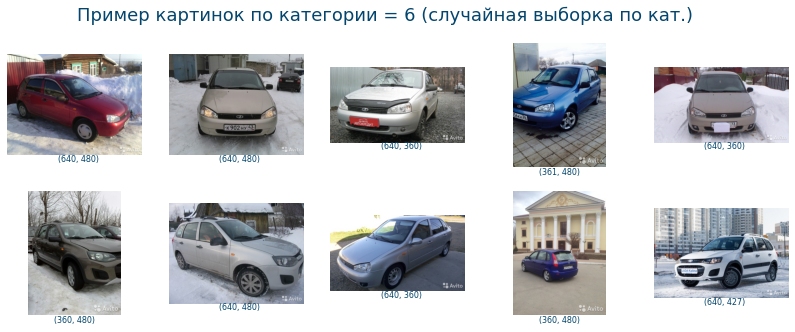

In [26]:
utils.images_from_dataset_with_path('Пример картинок по категории = 6 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*6, 'Id', RANDOM_SEED, False)

6 категория - Lada Kalina

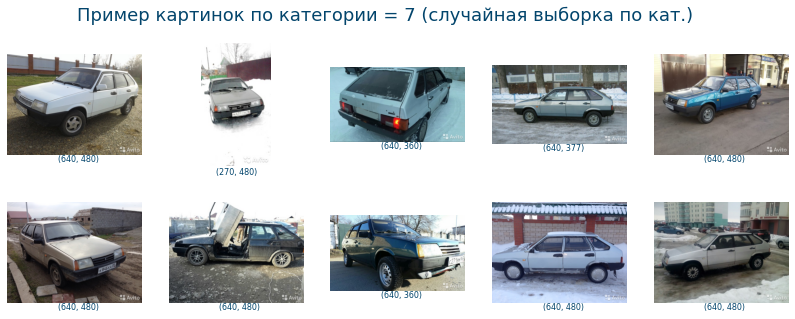

In [27]:
utils.images_from_dataset_with_path('Пример картинок по категории = 7 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*7, 'Id', RANDOM_SEED, False)

7 категория - Lada Samara 2109

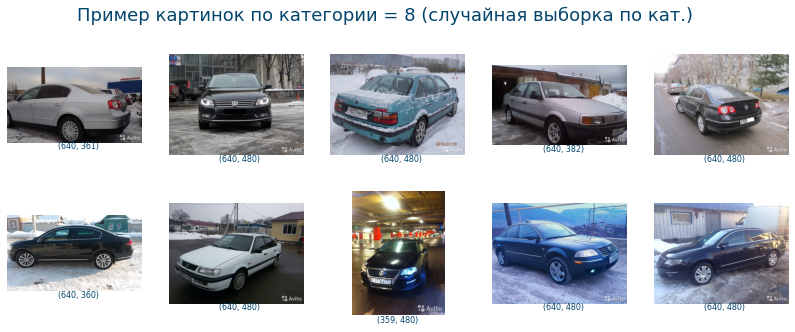

In [28]:
utils.images_from_dataset_with_path('Пример картинок по категории = 8 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*8, 'Id', RANDOM_SEED, False)

8 категория - Volkswagen Passat

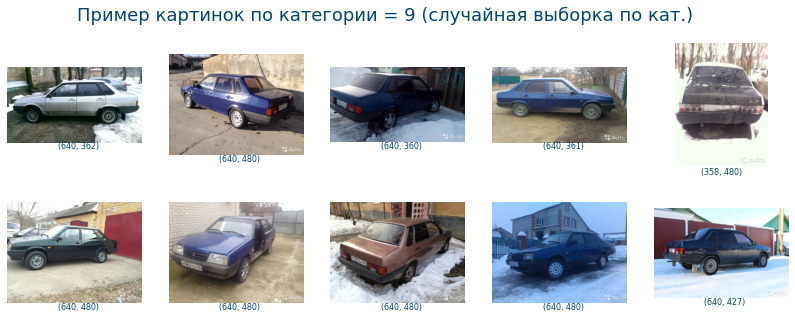

In [29]:
utils.images_from_dataset_with_path('Пример картинок по категории = 9 (случайная выборка по кат.)', '',PATH_to_IMAGES+'train/', df_train, 'Category', np.ones(10, dtype=int)*9, 'Id', RANDOM_SEED, False)

9 категория - Lada Samara 21099

Резюме: 
- Для классификации представлены фотографии 10 классов авто Lada
- Категории достаточно сбалансированны
- Размеры фотографий различаются, но в основном 640 на 480. Цветные.
- Всего 15561 фотография (это не достаточно для хорошего обучения модели нейронной сети, поэтому будем применять различные виды аугментации данных)


### 4. Инициализация датасета для хранения ВСЕХ! гиперпараметров и результатов экспериментов
Создание и обучение модели включает в себя:
- аугментацию данных (AUG)
- загрузку основы для модели (M)
- создание архитектуры головы (H)
- предварительное обучение модели (F)
- дообучение модели Fine-tuning (FT)
На каждом этапе нам потребуются какие-то гиперпараметры. К сожалению сохранение модели в формате h5(hdf5) сохраняет только частично информацию с этапов (M) и (H) с обученными весами модели. Мне оказалось этого не достаточно для анализа оптимальных гиперпараметров поэтому я решил создать датасет с результатами экспериментов.  

In [74]:
### ЭТУ СТРОКУ НАДО УДАЛИТЬ ИЗ ФИНАЛЬНОЙ ВЕРСИИ НОУТА
reload(utils)

<module 'utils_module09122020' from '/home/aleks/GitHub/skillfactory_rds/module_7/utils_module09122020.py'>

In [75]:
results_of_exp = pd.DataFrame()  # датафрейм для хранения гиперпараметров и результатов экспериментов
descr_hyperp_of_exp = {}  # словарь для хранения описания гиперпарамметров
NUM_EXP = utils.hyperp('NUM_EXP',1,'Номер эксперимента',results_of_exp,descr_hyperp_of_exp)  # инициализация всех гиперпараметров происходит через специальный метод

NUM_EXP = 1 (Номер эксперимента). Константа инициализирована.


### 5. Предварительная обработка фотографий для обучения модели (препроцессинг)
#### 5.1 Инициализация гиперпараметров для Аугментации фото

In [76]:
AUG_ROTATION_RANGE = utils.hyperp('AUG_ROTATION_RANGE', 10, 'Аугментация. Диапазон для случайных поворотов в градусах',results_of_exp,descr_hyperp_of_exp)
AUG_BRIGHTNES_RANGE = utils.hyperp('AUG_BRIGHTNES_RANGE', [0.5, 1.5], 'Аугментация. Диапазон выбора значения сдвига яркости',results_of_exp,descr_hyperp_of_exp)
AUG_WIDTH_SHIFT_RANGE = utils.hyperp('AUG_WIDTH_SHIFT_RANGE', 0.1, 'Аугментация. Диапазон выбора значения сдвига ширины',results_of_exp,descr_hyperp_of_exp)
AUG_HEIGHT_SHIFT_RANGE = utils.hyperp('AUG_HEIGHT_SHIFT_RANGE', 0.1, 'Аугментация. Диапазон выбора значения сдвига высоты',results_of_exp,descr_hyperp_of_exp)
AUG_HORIZONTAL_FLIP = utils.hyperp('AUG_HORIZONTAL_FLIP', True, 'Аугментация. Логическое значение для произвольного  переворачивания по горизонтали',results_of_exp,descr_hyperp_of_exp)
AUG_RESCALE = utils.hyperp('AUG_RESCALE', 1. / 255, 'Аугментация. Коэффициент масштабирования. Мы умножаем данные на это значение (после применения всех других преобразований)',results_of_exp,descr_hyperp_of_exp)
AUG_VAL_SPLIT = utils.hyperp('AUG_VAL_SPLIT', 0.2, 'Аугментация. Доля выборки оставляемой для валидации вне тренировочной выборки',results_of_exp,descr_hyperp_of_exp)

AUG_ROTATION_RANGE = 10 (Аугментация. Диапазон для случайных поворотов в градусах). Константа инициализирована.
AUG_BRIGHTNES_RANGE = [0.5, 1.5] (Аугментация. Диапазон выбора значения сдвига яркости). Константа инициализирована.
AUG_WIDTH_SHIFT_RANGE = 0.1 (Аугментация. Диапазон выбора значения сдвига ширины). Константа инициализирована.
AUG_HEIGHT_SHIFT_RANGE = 0.1 (Аугментация. Диапазон выбора значения сдвига высоты). Константа инициализирована.
AUG_HORIZONTAL_FLIP = True (Аугментация. Логическое значение для произвольного  переворачивания по горизонтали). Константа инициализирована.
AUG_RESCALE = 0.00392156862745098 (Аугментация. Коэффициент масштабирования. Мы умножаем данные на это значение (после применения всех других преобразований)). Константа инициализирована.
AUG_VAL_SPLIT = 0.2 (Аугментация. Доля выборки оставляемой для валидации вне тренировочной выборки). Константа инициализирована.


### 5.2 Аугментация данных

### 6. Модель
#### 6.1 Сборка модели
##### 6.1.1 Загрузка предобученной модели
##### 6.1.2 Задаем архитектуру головы
##### 6.1.3 Обучаем 
##### 6.1.4 Формируем первое приближение оптимальных гиперпараметров
#### 6.2 Transfer learning с Fine-tuning
##### 6.2.1 Шаг 1. Замораживаем базовую часть модели полностью
##### 6.2.2 Шаг 2. Разморозка половины слоев базовой модели + уменьшаем шаг обучения
##### 6.2.3 Шаг 3. Разморозка всех слоев базовой модели + уменьшаем шаг обучения
#### 6.3 Дообучение модели на увеличенном размере изображения



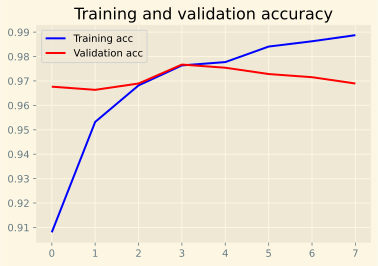

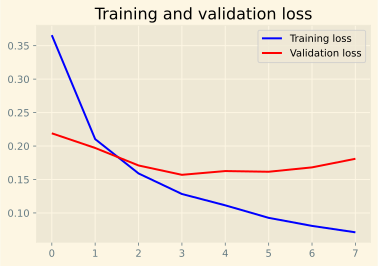

In [44]:
plot_history(history)

In [45]:
step = 4
now = dt.now().strftime('%d%m%Y_%H%M')
best_model_name = f'best_model_{step}_{now}.hdf5'
model.save(best_model_name )
# last_full_model_name = f'last_full_model_{step}_{now}.h5'
# model.save(last_full_model_name)

### 7. Формируем файл с предсказанием на тесте
#### 7.1. Предсказание без TTA

In [46]:
test_generator.samples

6675

In [47]:
test_generator.reset()
predictions = model.predict_generator(test_generator, verbose=1) 
predictions = np.argmax(predictions, axis=-1)  #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items())  # flip k, v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 82s 98ms/step


In [48]:
submission = pd.DataFrame({'Id': test_generator.filenames, 
                           'Category': predictions}, 
                          columns=['Id', 'Category'])

submission.head()

,Id,Category
0,305108.jpg,2
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,7


#### 7.2. Предсказание c TTA

In [50]:
model.load_weights('best_model.hdf5')

In [53]:
tta_steps = 10   # берем среднее за 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_generator, verbose=1)
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

835/835 [==============================] - 459s 550ms/step


In [54]:
predictions = np.argmax(pred, axis=-1)

label_map = (train_generator.class_indices)
label_map = dict((v, k) for k, v in label_map.items()) # flip k, v

predictions = [label_map[k] for k in predictions]

submission = pd.DataFrame({'Id': test_generator.filenames, 
                           'Category': predictions})

submission.head()

,Id,Category
0,305108.jpg,2
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,7
4,87877.jpg,9
